In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv


The project was about on time-series forecasting of cinema audience attendance using booking data from two different platforms:

BookNow- Online booking platform

CinePOS- Point-of-sale system at theatre premises

The goal is to predict the audience_count for each theatre on each date.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
cinepos_theaters  = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv')
booknow_theaters  = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv')
theater_relation  = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv')
cinepos_booking   = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv')
booknow_booking   = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv')
booknow_visits    = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv')
date_info         = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv')
sample_submission = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv')

Here I have load all the dataset-

**cinePOS_theaters.csv**- Theatre information from the CinePOS system

**booknow_theaters.csv**- Theatre information from the BookNow platform

**movie_theater_id_relation.csv**- Mapping between BookNow theatre IDs and CinePOS theatre IDs

**cinePOS_booking.csv**- On-premise POS ticket sales

**booknow_booking.csv**- Online ticket bookings

**booknow_visits.csv**- Daily audience counts (target variable)

**date_info.csv**- Calendar information: holiday_flag, day_of_week.

**sample_submission.csv**- Required submission format

# **EDA for cinepos_theaters**

In [4]:
cinepos_theaters.shape

(4690, 5)

cinepos_theaters have 4690 rows with 5 columns 

In [5]:
cinepos_theaters.head()

,cine_theater_id,theater_type,theater_area,latitude,longitude
0,cinePOS_05466,Other,Area_104,22.619233,78.113017
1,cinePOS_08708,Other,Area_104,22.619233,78.113017
2,cinePOS_00753,Other,Area_104,22.619233,78.113017
3,cinePOS_05776,Other,Area_104,22.619233,78.113017
4,cinePOS_07536,Other,Area_104,23.004410,79.934515


In [6]:
cinepos_theaters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4690 entries, 0 to 4689
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cine_theater_id  4690 non-null   object 
 1   theater_type     4690 non-null   object 
 2   theater_area     4690 non-null   object 
 3   latitude         829 non-null    float64
 4   longitude        829 non-null    float64
dtypes: float64(2), object(3)
memory usage: 183.3+ KB


**cine_theater_id** — Unique identifier for each theater.

**theater_type** — Type/category of the theater.

**theater_area** — Area or locality where the theater is situated.

**latitude** — Latitude coordinate.

**longitude** — Longitude coordinate.

In [7]:
cinepos_theaters.isnull().sum()

cine_theater_id       0
theater_type          0
theater_area          0
latitude           3861
longitude          3861
dtype: int64

Got 3861 null values from 4690

In [8]:
cinepos_theaters.isnull().sum()/4690*100

cine_theater_id     0.000000
theater_type        0.000000
theater_area        0.000000
latitude           82.324094
longitude          82.324094
dtype: float64

About 82 percent values are null in latitude and longitude column that means they have no use in our final master dataset

In [9]:
cinepos_theaters.nunique()

cine_theater_id    4690
theater_type          3
theater_area        119
latitude            108
longitude           108
dtype: int64

In [10]:
cinepos_theaters_cleaned = cinepos_theaters.copy()
cinepos_theaters_cleaned.drop(columns=['latitude', 'longitude'], inplace=True)

I havde made the copy of dataset because I don't want make changes in raw data because it can be use further in my project. 

Since more than 82% of latitude/longitude values were missing and location was not directly required for forecasting, these columns were dropped to avoid noise and unnecessary dimensionality.

In [11]:
cinepos_theaters_cleaned.head()

,cine_theater_id,theater_type,theater_area
0,cinePOS_05466,Other,Area_104
1,cinePOS_08708,Other,Area_104
2,cinePOS_00753,Other,Area_104
3,cinePOS_05776,Other,Area_104
4,cinePOS_07536,Other,Area_104


In [12]:
cinepos_theaters_cleaned.describe()

,cine_theater_id,theater_type,theater_area
count,4690,4690,4690
unique,4690,3,119
top,cinePOS_00501,Other,Area_119
freq,1,3941,257


This dataset contains clean, unique IDs, a dominant theater type, and a wide spread of areas with some clusters in specific locations.

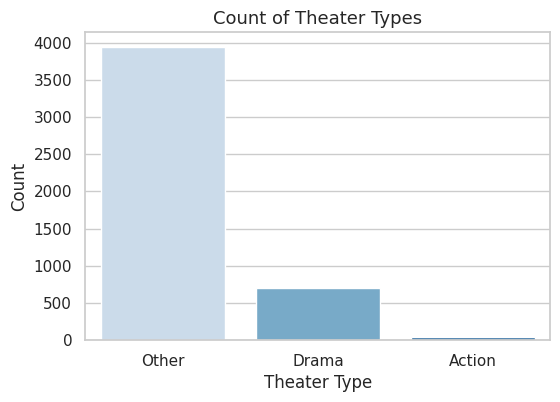

In [13]:
sns.set(style="whitegrid")

plt.figure(figsize=(6,4))
sns.countplot(
    data=cinepos_theaters_cleaned,
    x="theater_type",
    palette="Blues", 
)
plt.title("Count of Theater Types", fontsize=13)
plt.xlabel("Theater Type")
plt.ylabel("Count")
plt.show()

The dataset is highly imbalanced in terms of **theater_type**

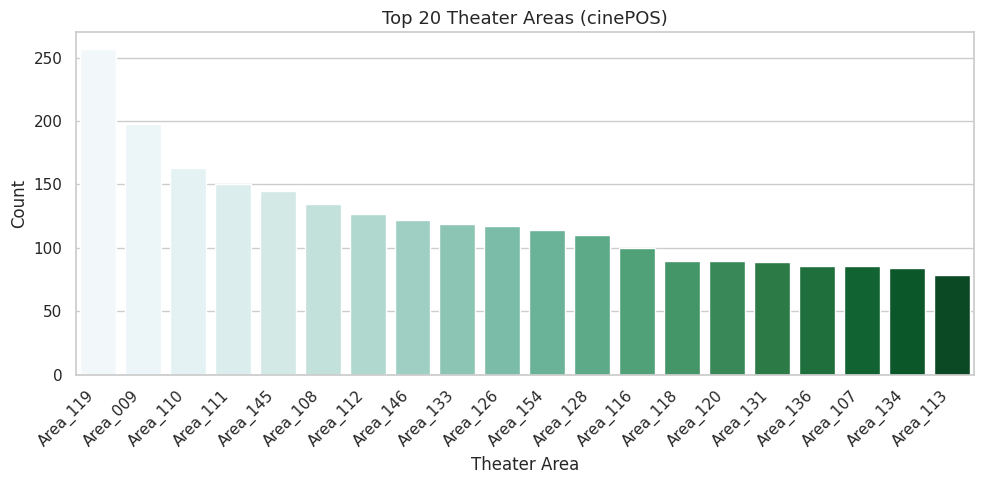

In [14]:
plt.figure(figsize=(10,5))

top_areas = (
    cinepos_theaters_cleaned["theater_area"]
    .value_counts()
    .head(20)
)

sns.barplot(
    x=top_areas.index,
    y=top_areas.values,
    palette="BuGn" 
)

plt.title("Top 20 Theater Areas (cinePOS)", fontsize=13)
plt.xlabel("Theater Area")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



* The area Area_119 has the highest concentration of theaters (257), making it the most represented region.
* Several areas have 100+ theaters, showing clusters of high theatre density.


# **EDA for booknow_theaters**

In [15]:
booknow_theaters.shape

(829, 5)

This Dataset have 829 rows with 5 columns 

In [16]:
booknow_theaters.head()

,book_theater_id,theater_type,theater_area,latitude,longitude
0,book_00093,Drama,Area_001,22.619233,78.113017
1,book_00078,Drama,Area_001,22.619233,78.113017
2,book_00291,Drama,Area_001,22.619233,78.113017
3,book_00258,Drama,Area_001,22.619233,78.113017
4,book_00212,Drama,Area_002,23.004410,79.934515


In [17]:
booknow_theaters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   book_theater_id  314 non-null    object 
 1   theater_type     829 non-null    object 
 2   theater_area     829 non-null    object 
 3   latitude         829 non-null    float64
 4   longitude        829 non-null    float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB


The dataset provides clean and complete geo-location details for all theaters on the BookNow platform, but the theater ID column is incomplete.

In [18]:
booknow_theaters.isnull().sum()

book_theater_id    515
theater_type         0
theater_area         0
latitude             0
longitude            0
dtype: int64

The dataset is mostly clean, except for the missing theater IDs.

In [19]:
booknow_theaters.isnull().sum()/829 *100

book_theater_id    62.12304
theater_type        0.00000
theater_area        0.00000
latitude            0.00000
longitude           0.00000
dtype: float64

As it has about 62 percent of null values so we should drop the null values 

In [20]:
booknow_theaters.nunique()

book_theater_id    314
theater_type         4
theater_area       103
latitude           108
longitude          108
dtype: int64

In [21]:
booknow_theaters_cleaned = booknow_theaters.copy()
booknow_theaters_cleaned.shape

(829, 5)

In [22]:
booknow_theaters_cleaned.dropna(subset=['book_theater_id'], inplace=True)

In [23]:
booknow_theaters_cleaned.shape

(314, 5)

So I have made a copy of raw dataset and drop the null values and our new shape of dataset has 314 rows with 5 columns 

In [24]:
booknow_theaters_cleaned.describe()

,latitude,longitude
count,314.000000,314.000000
mean,23.134616,78.969717
std,1.041943,1.470878
min,22.025970,76.173250
25%,22.618118,78.113017
50%,23.004410,79.905266
75%,23.018784,79.935314
max,26.349436,81.743235


The latitude and longitude values stay within a tight range, showing that all theaters are located within a small and consistent geographic region.

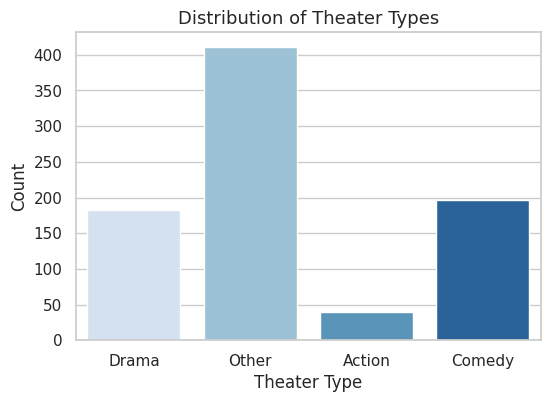

In [25]:
plt.figure(figsize=(6,4))
sns.countplot(
    data=booknow_theaters,
    x="theater_type",
    palette="Blues"  
)
plt.title("Distribution of Theater Types", fontsize=13)
plt.xlabel("Theater Type")
plt.ylabel("Count")
plt.show()

Dataset Theater has too many **other** types 

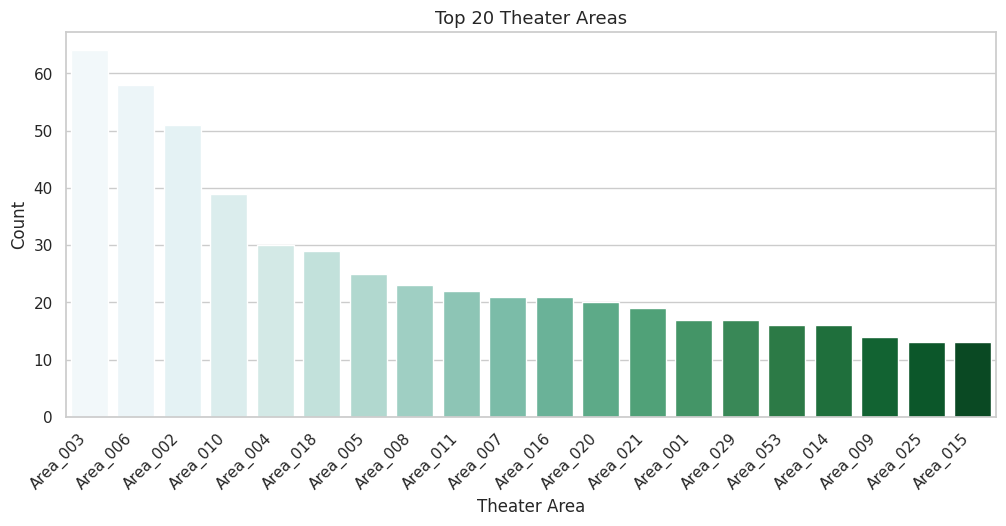

In [26]:
plt.figure(figsize=(12,5))

top_areas = (
    booknow_theaters["theater_area"]
    .value_counts()
    .head(20)
)

sns.barplot(
    x=top_areas.index,
    y=top_areas.values,
    palette="BuGn"   
)

plt.title("Top 20 Theater Areas", fontsize=13)
plt.xlabel("Theater Area")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show()

Some areas have more theaters, meaning theaters are mostly grouped in a few regions.

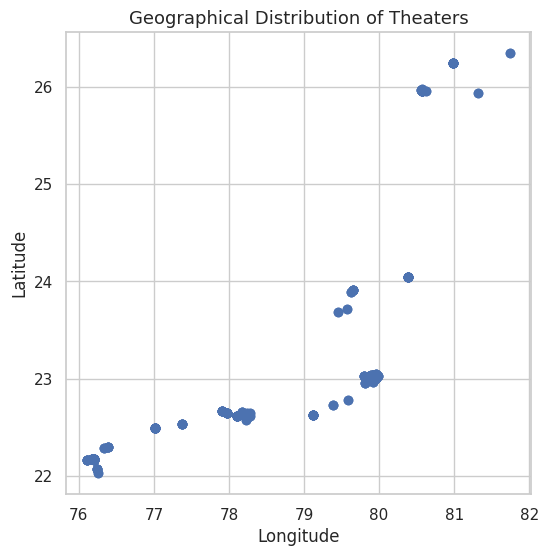

In [27]:
plt.figure(figsize=(6,6))
plt.scatter(
    booknow_theaters["longitude"],
    booknow_theaters["latitude"]
)
plt.title("Geographical Distribution of Theaters", fontsize=13)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


The theaters are spread across a wide geographic area, but most of them fall into a few clustered regions.

# **EDA for theater_relation**

In [28]:
theater_relation.shape

(150, 2)

This Dataset have 150 rows with 2 columns

In [29]:
theater_relation.head()

,book_theater_id,cine_theater_id
0,book_00509,cinePOS_01261
1,book_00063,cinePOS_02467
2,book_00054,cinePOS_08923
3,book_00094,cinePOS_02479
4,book_00052,cinePOS_06750


In [30]:
theater_relation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   book_theater_id  150 non-null    object
 1   cine_theater_id  150 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB


This dataset just links BookNow theater IDs with CinePOS theater IDs.

In [31]:
theater_relation.isnull().sum()

book_theater_id    0
cine_theater_id    0
dtype: int64

It has no missing values.

In [32]:
theater_relation.nunique()

book_theater_id    150
cine_theater_id    150
dtype: int64

In [33]:
theater_relation_cleaned = theater_relation.copy()

Just for consistency I have also made the copy of this Dataset also.

# **EDA for cinepos_booking**

In [34]:
cinepos_booking.shape

(1641966, 4)

The cinePOS booking dataset is very large, with 1641966 rows and 4 columns.

In [35]:
cinepos_booking.head()

,cine_theater_id,show_datetime,booking_datetime,tickets_sold
0,cinePOS_00001,2023-01-01 11:00:00,2023-01-01 09:00:00,1
1,cinePOS_00002,2023-01-01 13:00:00,2023-01-01 06:00:00,3
2,cinePOS_00003,2023-01-01 16:00:00,2023-01-01 14:00:00,2
3,cinePOS_00004,2023-01-01 17:00:00,2023-01-01 11:00:00,5
4,cinePOS_00005,2023-01-01 17:00:00,2023-01-01 03:00:00,13


In [36]:
cinepos_booking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1641966 entries, 0 to 1641965
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   cine_theater_id   1641966 non-null  object
 1   show_datetime     1641966 non-null  object
 2   booking_datetime  1641966 non-null  object
 3   tickets_sold      1641966 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 50.1+ MB


In [37]:
cinepos_booking.isnull().sum()

cine_theater_id     0
show_datetime       0
booking_datetime    0
tickets_sold        0
dtype: int64

The cinePOS booking dataset is complete with no missing values and contains theater IDs, timestamps, and ticket counts for each booking.

In [38]:
cinepos_booking.nunique()

cine_theater_id     13161
show_datetime        8283
booking_datetime    10152
tickets_sold           97
dtype: int64

In [39]:
cinepos_booking.duplicated().sum()

12541

In [40]:
cinepos_booking=cinepos_booking.drop_duplicates().reset_index(drop= True)

In [41]:
cinepos_booking_cleaned = cinepos_booking.copy()

The dataset had about 12.5k duplicate rows, which were removed to keep only unique booking records.

In [42]:
cinepos_booking_cleaned.describe()

,tickets_sold
count,1.629425e+06
mean,4.989092e+00
std,5.236935e+00
min,1.000000e+00
25%,2.000000e+00
50%,3.000000e+00
75%,6.000000e+00
max,1.000000e+02


Most bookings sell only a few tickets, but some shows sell much more, as seen from the high maximum value.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


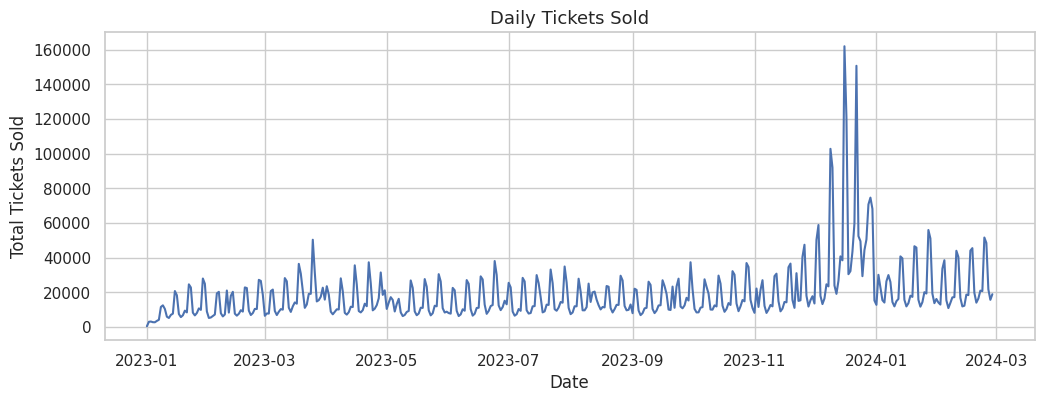

In [43]:
df = cinepos_booking_cleaned.copy()
df["show_datetime"] = pd.to_datetime(df["show_datetime"])
df["show_date"] = df["show_datetime"].dt.date

daily = df.groupby("show_date")["tickets_sold"].sum().reset_index()

plt.figure(figsize=(12,4))
sns.lineplot(data=daily, x="show_date", y="tickets_sold")
plt.title("Daily Tickets Sold", fontsize=13)
plt.xlabel("Date")
plt.ylabel("Total Tickets Sold")
plt.show()


Daily ticket sales stay fairly steady but show big spikes around 12-2023, likely due to popular movie releases or holidays.

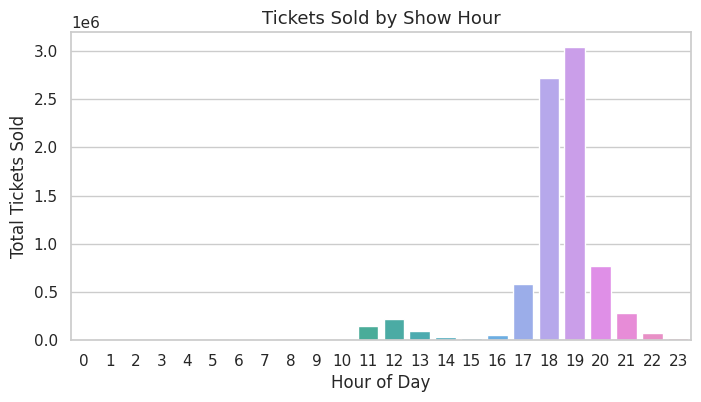

In [44]:
df["show_hour"] = df["show_datetime"].dt.hour

hourly = (
    df.groupby("show_hour")["tickets_sold"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(8,4))
sns.barplot(
    data=hourly,
    x="show_hour",
    y="tickets_sold",
    errorbar=None
)
plt.title("Tickets Sold by Show Hour", fontsize=13)
plt.xlabel("Hour of Day")
plt.ylabel("Total Tickets Sold")
plt.show()

Tickets are sold more in the late evening hours, while midday shows see lower sales.

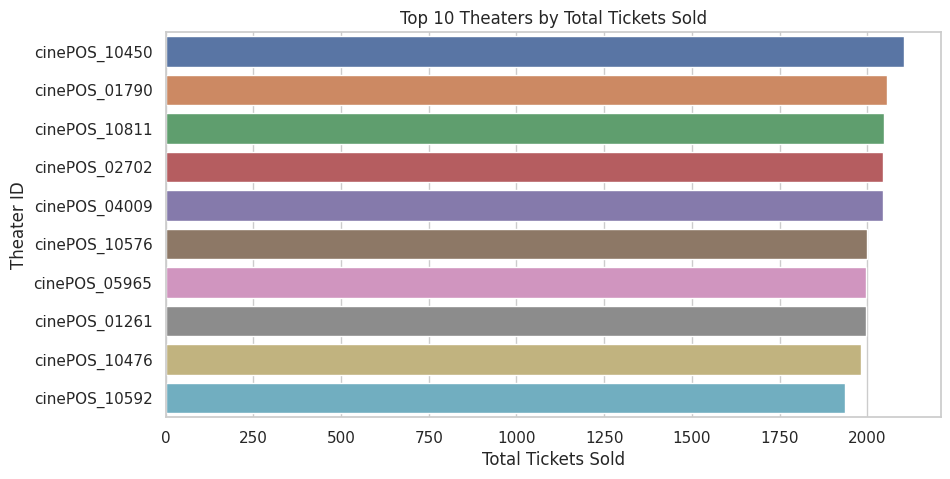

In [45]:
top_theaters = (
    df.groupby("cine_theater_id")["tickets_sold"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10,5))
sns.barplot(
    x=top_theaters.values,
    y=top_theaters.index
)
plt.title("Top 10 Theaters by Total Tickets Sold")
plt.xlabel("Total Tickets Sold")
plt.ylabel("Theater ID")
plt.show()


These theaters sold the most tickets overall.

# **EDA for booknow_booking**

In [46]:
booknow_booking.shape

(68336, 4)

The BookNow booking dataset has around 68k rows and 4 columns, making it much smaller than the POS dataset.

In [47]:
booknow_booking.head()

,book_theater_id,show_datetime,booking_datetime,tickets_booked
0,book_00244,2023-01-01 19:00:00,2023-01-01 16:00:00,1
1,book_00740,2023-01-01 19:00:00,2023-01-01 19:00:00,3
2,book_00740,2023-01-01 19:00:00,2023-01-01 19:00:00,6
3,book_00244,2023-01-01 20:00:00,2023-01-01 16:00:00,2
4,book_00151,2023-01-01 20:00:00,2023-01-01 01:00:00,5


In [48]:
booknow_booking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68336 entries, 0 to 68335
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   book_theater_id   68336 non-null  object
 1   show_datetime     68336 non-null  object
 2   booking_datetime  68336 non-null  object
 3   tickets_booked    68336 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.1+ MB


In [49]:
booknow_booking.isnull().sum()

book_theater_id     0
show_datetime       0
booking_datetime    0
tickets_booked      0
dtype: int64

All columns in the BookNow booking data are complete, with each row showing a theater ID, timestamps, and the number of tickets booked.

In [50]:
booknow_booking.nunique()

book_theater_id      301
show_datetime       3866
booking_datetime    6351
tickets_booked        66
dtype: int64

In [51]:
booknow_booking.duplicated().sum()

2042

In [52]:
booknow_booking= booknow_booking.drop_duplicates().reset_index(drop=True)

In [53]:
booknow_booking_cleaned = booknow_booking.copy()

In [54]:
booknow_booking_cleaned.describe()

,tickets_booked
count,66294.000000
mean,4.482442
std,4.840031
min,1.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,100.000000


Most online bookings are small, but a few large bookings push the maximum ticket count much higher.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


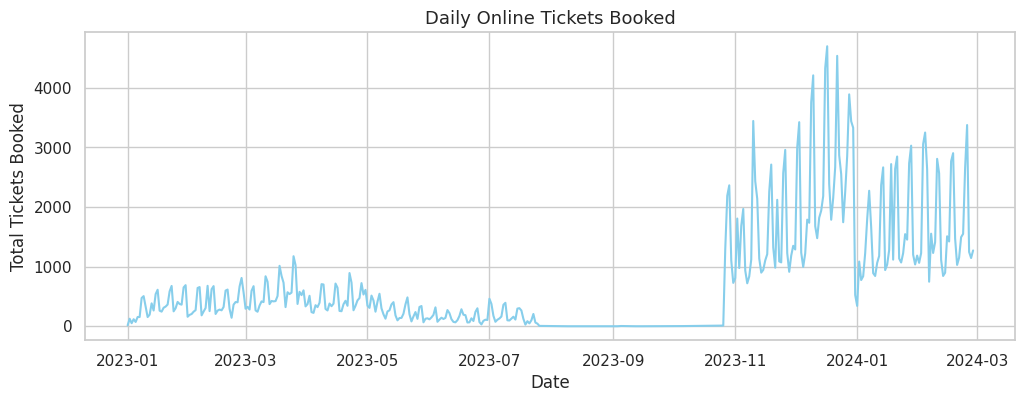

In [55]:
df = booknow_booking.copy()
df["show_datetime"] = pd.to_datetime(df["show_datetime"])
df["show_date"] = df["show_datetime"].dt.date

daily = df.groupby("show_date")["tickets_booked"].sum().reset_index()

plt.figure(figsize=(12,4))
sns.lineplot(data=daily, x="show_date", y="tickets_booked", color="skyblue")
plt.title("Daily Online Tickets Booked", fontsize=13)
plt.xlabel("Date")
plt.ylabel("Total Tickets Booked")
plt.show()

Online ticket bookings stay low for most of the year but rise sharply during the later months.

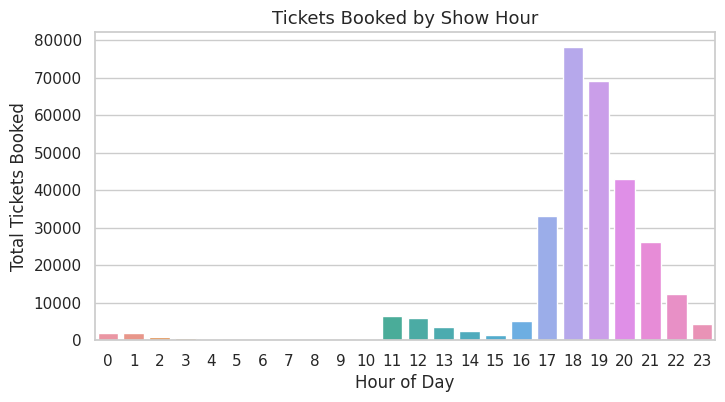

In [56]:
df["show_hour"] = df["show_datetime"].dt.hour

hourly = (
    df.groupby("show_hour")["tickets_booked"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(8,4))
sns.barplot(
    data=hourly,
    x="show_hour",
    y="tickets_booked",
    errorbar=None
)
plt.title("Tickets Booked by Show Hour", fontsize=13)
plt.xlabel("Hour of Day")
plt.ylabel("Total Tickets Booked")
plt.show()


Most online bookings happen in the evening hours, with very few bookings earlier in the day.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


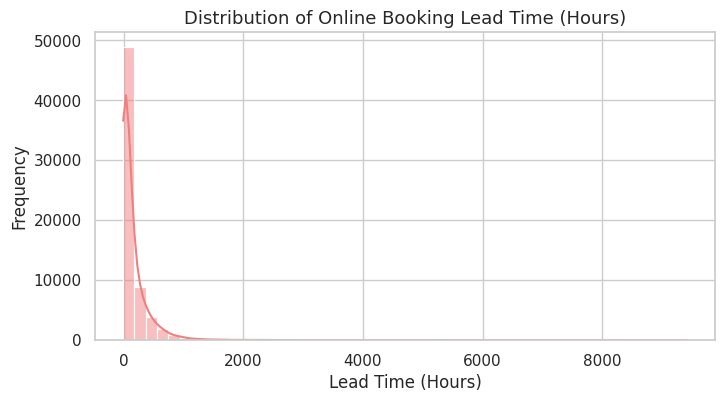

In [57]:
df["booking_datetime"] = pd.to_datetime(df["booking_datetime"])
df["lead_hours"] = (df["show_datetime"] - df["booking_datetime"]).dt.total_seconds() / 3600

plt.figure(figsize=(8,4))
sns.histplot(df["lead_hours"], bins=50, kde=True, color="lightcoral")
plt.title("Distribution of Online Booking Lead Time (Hours)", fontsize=13)
plt.xlabel("Lead Time (Hours)")
plt.ylabel("Frequency")
plt.show()

Most bookings happen very close to the show time, with only a small number made many hours in advance.

# **EDA for booknow_visits**

In [58]:
booknow_visits.shape


(214046, 3)

The BookNow visits dataset has about 214046 rows and 3 columns.

In [59]:
booknow_visits.head()

,book_theater_id,show_date,audience_count
0,book_00001,2023-01-13,50
1,book_00001,2023-01-14,64
2,book_00001,2023-01-15,58
3,book_00001,2023-01-16,44
4,book_00001,2023-01-18,12


In [60]:
booknow_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214046 entries, 0 to 214045
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   book_theater_id  214046 non-null  object
 1   show_date        214046 non-null  object
 2   audience_count   214046 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.9+ MB


In [61]:
booknow_visits.isnull().sum()


book_theater_id    0
show_date          0
audience_count     0
dtype: int64

This dataset is complete, with each row showing a theater, a date, and the audience count (target variable) for that day.

In [62]:
booknow_visits.nunique()

book_theater_id    826
show_date          424
audience_count     191
dtype: int64

In [63]:
booknow_visits.duplicated().sum()

10

In [64]:
booknow_visits=booknow_visits.drop_duplicates().reset_index(drop=True)

There were only a few duplicate rows, and they were removed to keep the visit data clean.

In [65]:
booknow_visits_cleaned=booknow_visits.copy()

In [66]:
booknow_visits_cleaned.describe()

,audience_count
count,214036.000000
mean,41.617728
std,32.835180
min,2.000000
25%,18.000000
50%,34.000000
75%,58.000000
max,1350.000000


Most theaters get a moderate number of visitors daily, but a few days have very high audience counts.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


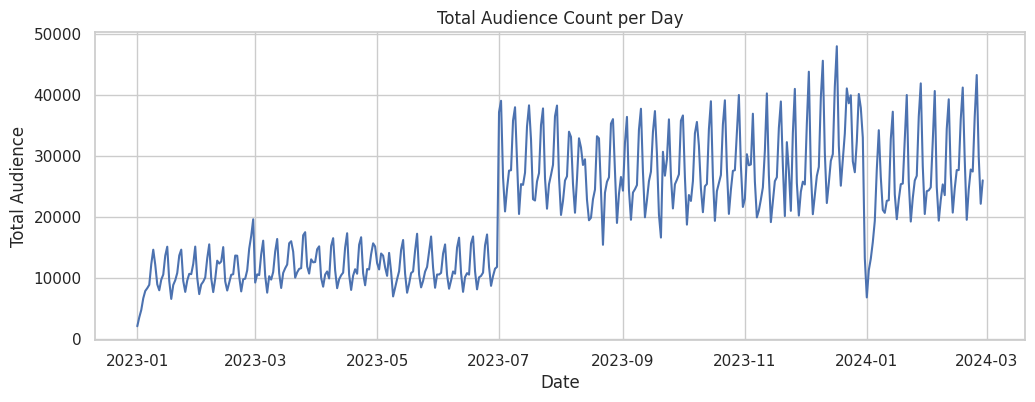

In [67]:
visits_ts = booknow_visits.copy()
visits_ts["show_date"] = pd.to_datetime(visits_ts["show_date"])

daily_audience = (
    visits_ts.groupby("show_date")["audience_count"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(12,4))
sns.lineplot(data=daily_audience, x="show_date", y="audience_count")
plt.title("Total Audience Count per Day")
plt.xlabel("Date")
plt.ylabel("Total Audience")
plt.show()


Daily audience counts rise over time with regular weekly patterns and occasional sharp spikes.

# **EDA for date_info**

In [68]:
date_info.shape

(547, 2)

This dataset has 547 rows and 2 columns, covering calendar dates with basic details like holidays.

In [69]:
date_info.head()

,show_date,day_of_week
0,2023-01-01,Sunday
1,2023-01-02,Monday
2,2023-01-03,Tuesday
3,2023-01-04,Wednesday
4,2023-01-05,Thursday


In [70]:
date_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   show_date    547 non-null    object
 1   day_of_week  547 non-null    object
dtypes: object(2)
memory usage: 8.7+ KB


This dataset is complete and provides each date along with its corresponding day of the week.

In [71]:
date_info.isnull().sum()

show_date      0
day_of_week    0
dtype: int64

In [72]:
date_info.nunique()

show_date      547
day_of_week      7
dtype: int64

In [73]:
date_info_cleaned = date_info.copy()

# **EDA for sample_submission**

In [74]:
sample_submission.shape

(38062, 2)

This dataset contains 38062 rows and 2 columns.

In [75]:
sample_submission.head()

,ID,audience_count
0,book_00001_2024-03-01,0
1,book_00001_2024-03-02,0
2,book_00001_2024-03-03,0
3,book_00001_2024-03-04,0
4,book_00001_2024-03-06,0


In [76]:
sample_submission.isnull().sum()

ID                0
audience_count    0
dtype: int64

In [77]:
sample_submission.nunique()

ID                38062
audience_count        1
dtype: int64

# **Merging Datasets**

The goal of this stage is to construct a single, unified dataset, this allows the model to learn patterns across all relevant dimensions.

In [78]:
master_df = booknow_visits_cleaned.copy()

Now I have to make the final or master dataset by taking the cleaned BookNow visits data as the base.

In [79]:
master_df.shape

(214036, 3)

In [80]:
master_df['show_date'] = pd.to_datetime(master_df['show_date'])
date_info_cleaned['show_date'] = pd.to_datetime(date_info_cleaned['show_date'])

master_df = pd.merge(master_df, date_info_cleaned, on='show_date', how='left')

I have merged the date information into the master dataset so each row now includes its day of the week.

In [81]:
master_df.shape

(214036, 4)

In [82]:
master_df = pd.merge(master_df, booknow_theaters_cleaned, on='book_theater_id', how='left')

Now I added theater details from the BookNow dataset to the master data using the theater ID.

In [83]:
master_df.shape

(214036, 8)

In [84]:
master_df.head()

,book_theater_id,show_date,audience_count,day_of_week,theater_type,theater_area,latitude,longitude
0,book_00001,2023-01-13,50,Friday,Drama,Area_002,23.00441,79.934515
1,book_00001,2023-01-14,64,Saturday,Drama,Area_002,23.00441,79.934515
2,book_00001,2023-01-15,58,Sunday,Drama,Area_002,23.00441,79.934515
3,book_00001,2023-01-16,44,Monday,Drama,Area_002,23.00441,79.934515
4,book_00001,2023-01-18,12,Wednesday,Drama,Area_002,23.00441,79.934515


In [85]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214036 entries, 0 to 214035
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   book_theater_id  214036 non-null  object        
 1   show_date        214036 non-null  datetime64[ns]
 2   audience_count   214036 non-null  int64         
 3   day_of_week      214036 non-null  object        
 4   theater_type     80145 non-null   object        
 5   theater_area     80145 non-null   object        
 6   latitude         80145 non-null   float64       
 7   longitude        80145 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 13.1+ MB


The merged dataset now has 8 columns, but many theater details are missing because several BookNow records don’t have matching theater IDs.

In [86]:
master_df.isnull().sum()

book_theater_id         0
show_date               0
audience_count          0
day_of_week             0
theater_type       133891
theater_area       133891
latitude           133891
longitude          133891
dtype: int64

In [87]:
master_df.isnull().sum()/214046 *100

book_theater_id     0.000000
show_date           0.000000
audience_count      0.000000
day_of_week         0.000000
theater_type       62.552442
theater_area       62.552442
latitude           62.552442
longitude          62.552442
dtype: float64

In [88]:
master_df['is_theater_info_missing'] = master_df['theater_type'].isnull().astype(int)

Around 62% of rows have missing theater information, so I have created a flag to mark which entries lack these details.

In [89]:
cat_cols= ['theater_type','theater_area']

In [90]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


ct=ColumnTransformer([
    ('cat',SimpleImputer(strategy='constant',fill_value='Unknown'),cat_cols)
],remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')


In [91]:
master_df=ct.fit_transform(master_df)

I have filled missing theater type and area values with “Unknown” to keep the dataset complete for modeling.

In [92]:
master_df=master_df.drop(columns=['latitude', 'longitude'])

I have dropped latitude and longitude because most values were missing and they didn’t provide useful information for our model.

In [93]:
master_df['is_theater_info_missing'].unique()

array([0, 1])

CinePOS data was skipped because it did not match well with the BookNow theatre IDs, so it created confusion instead of helping the model.

# **Feature Engineering**

In [94]:
master_df['show_date'] = pd.to_datetime(master_df['show_date'])

master_df['year'] = master_df['show_date'].dt.year
master_df['month'] = master_df['show_date'].dt.month
master_df['day'] = master_df['show_date'].dt.day
master_df['week_of_year'] = master_df['show_date'].dt.isocalendar().week.astype(int)
master_df['is_weekend'] = (master_df['day_of_week'].isin(['Saturday', 'Sunday'])).astype(int)

Now I have created new date-based features like year, month, week, and weekend to help the model learn time patterns in audience behavior.

In [95]:
book_bookings = booknow_booking_cleaned.copy()
book_bookings['show_datetime'] = pd.to_datetime(book_bookings['show_datetime'])
book_bookings['booking_datetime'] = pd.to_datetime(book_bookings['booking_datetime'])
book_bookings['show_date'] = pd.to_datetime(book_bookings['show_datetime'].dt.date)

book_bookings['booking_lead_days'] = (book_bookings['show_datetime'] - book_bookings['booking_datetime']).dt.total_seconds() / (24 * 60 * 60)

online_features = book_bookings.groupby(['book_theater_id', 'show_date']).agg(
    total_online_tickets=('tickets_booked', 'sum'),
    avg_online_lead_days=('booking_lead_days', 'mean')
).reset_index()

master_df = pd.merge(master_df, online_features, on=['book_theater_id', 'show_date'], how='left')

In [96]:
master_df.tail()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,theater_type,theater_area,book_theater_id,show_date,audience_count,day_of_week,is_theater_info_missing,year,month,day,week_of_year,is_weekend,total_online_tickets,avg_online_lead_days
214031,Unknown,Unknown,book_00829,2024-02-23,16,Friday,1,2024,2,23,8,0,NaN,NaN
214032,Unknown,Unknown,book_00829,2024-02-24,8,Saturday,1,2024,2,24,8,1,NaN,NaN
214033,Unknown,Unknown,book_00829,2024-02-25,16,Sunday,1,2024,2,25,8,1,NaN,NaN
214034,Unknown,Unknown,book_00829,2024-02-27,16,Tuesday,1,2024,2,27,9,0,NaN,NaN
214035,Unknown,Unknown,book_00829,2024-02-28,16,Wednesday,1,2024,2,28,9,0,NaN,NaN


In [97]:
pos_bookings = cinepos_booking_cleaned.copy()
pos_bookings_linked = pd.merge(pos_bookings, theater_relation_cleaned, on='cine_theater_id', how='inner')
pos_bookings_linked['show_datetime'] = pd.to_datetime(pos_bookings_linked['show_datetime'])
pos_bookings_linked['show_date'] = pd.to_datetime(pos_bookings_linked['show_datetime'].dt.date)

pos_features = pos_bookings_linked.groupby(['book_theater_id', 'show_date']).agg(
    total_pos_tickets=('tickets_sold', 'sum')
).reset_index()

master_df = pd.merge(master_df, pos_features, on=['book_theater_id', 'show_date'], how='left')

In [98]:
master_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,theater_type,theater_area,book_theater_id,show_date,audience_count,day_of_week,is_theater_info_missing,year,month,day,week_of_year,is_weekend,total_online_tickets,avg_online_lead_days,total_pos_tickets
0,Drama,Area_002,book_00001,2023-01-13,50,Friday,0,2023,1,13,2,0,NaN,NaN,NaN
1,Drama,Area_002,book_00001,2023-01-14,64,Saturday,0,2023,1,14,2,1,NaN,NaN,NaN
2,Drama,Area_002,book_00001,2023-01-15,58,Sunday,0,2023,1,15,2,1,NaN,NaN,NaN
3,Drama,Area_002,book_00001,2023-01-16,44,Monday,0,2023,1,16,3,0,NaN,NaN,NaN
4,Drama,Area_002,book_00001,2023-01-18,12,Wednesday,0,2023,1,18,3,0,NaN,NaN,NaN


In [99]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214036 entries, 0 to 214035
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   theater_type             214036 non-null  object        
 1   theater_area             214036 non-null  object        
 2   book_theater_id          214036 non-null  object        
 3   show_date                214036 non-null  datetime64[ns]
 4   audience_count           214036 non-null  int64         
 5   day_of_week              214036 non-null  object        
 6   is_theater_info_missing  214036 non-null  int64         
 7   year                     214036 non-null  int32         
 8   month                    214036 non-null  int32         
 9   day                      214036 non-null  int32         
 10  week_of_year             214036 non-null  int64         
 11  is_weekend               214036 non-null  int64         
 12  total_online_tic

In [100]:
feature_cols =['total_online_tickets', 'avg_online_lead_days', 'total_pos_tickets']

In [101]:
ctf=ColumnTransformer([
    ('fea',SimpleImputer(strategy='constant',fill_value=0),feature_cols)
],remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')

In [102]:
master_df=ctf.fit_transform(master_df)

I have filled missing numeric feature values with zero so the model can use them without errors.

In [103]:
master_df.drop(columns=['show_date'], inplace=True)

I have dropped the show_date column because all useful date information has already been extracted into new features.

In [104]:
master_df.head()

,total_online_tickets,avg_online_lead_days,total_pos_tickets,theater_type,theater_area,book_theater_id,audience_count,day_of_week,is_theater_info_missing,year,month,day,week_of_year,is_weekend
0,0.0,0.0,0.0,Drama,Area_002,book_00001,50,Friday,0,2023,1,13,2,0
1,0.0,0.0,0.0,Drama,Area_002,book_00001,64,Saturday,0,2023,1,14,2,1
2,0.0,0.0,0.0,Drama,Area_002,book_00001,58,Sunday,0,2023,1,15,2,1
3,0.0,0.0,0.0,Drama,Area_002,book_00001,44,Monday,0,2023,1,16,3,0
4,0.0,0.0,0.0,Drama,Area_002,book_00001,12,Wednesday,0,2023,1,18,3,0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


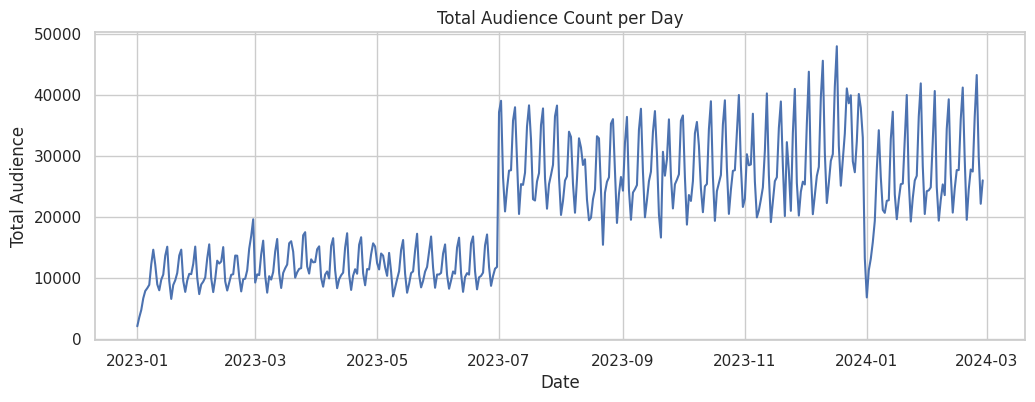

In [105]:
master_ts = master_df.copy()
master_ts["show_date"] = pd.to_datetime(master_ts[["year", "month", "day"]])

daily_master = (
    master_ts.groupby("show_date")["audience_count"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(12,4))
sns.lineplot(data=daily_master, x="show_date", y="audience_count")
plt.title("Total Audience Count per Day")
plt.xlabel("Date")
plt.ylabel("Total Audience")
plt.show()


The final master dataset shows the same daily audience trend as before, confirming that the merging and feature engineering didn’t change the overall pattern.

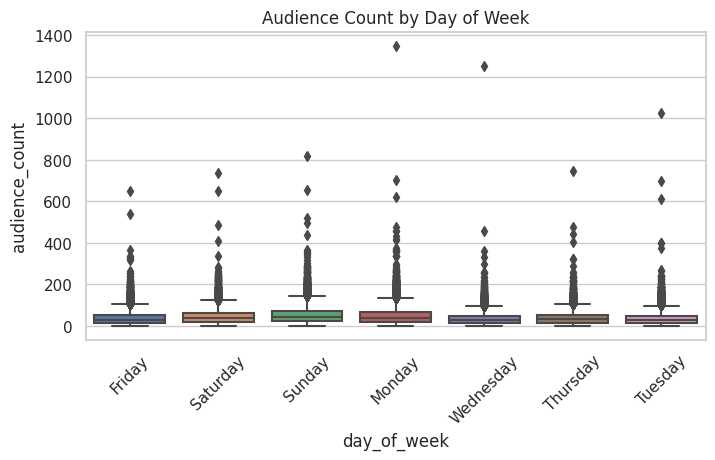

In [106]:
plt.figure(figsize=(8,4))
sns.boxplot(data=master_df, x="day_of_week", y="audience_count")
plt.title("Audience Count by Day of Week")
plt.xticks(rotation=45)
plt.show()

Weekend days, especially Sunday, tend to have higher audience counts compared to weekdays.

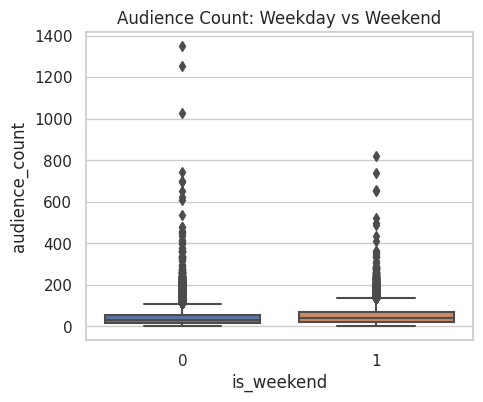

In [107]:
plt.figure(figsize=(5,4))
sns.boxplot(data=master_df, x="is_weekend", y="audience_count")
plt.title("Audience Count: Weekday vs Weekend")
plt.show()

Weekend audience counts are slightly higher than weekdays, with more big spikes on weekends.

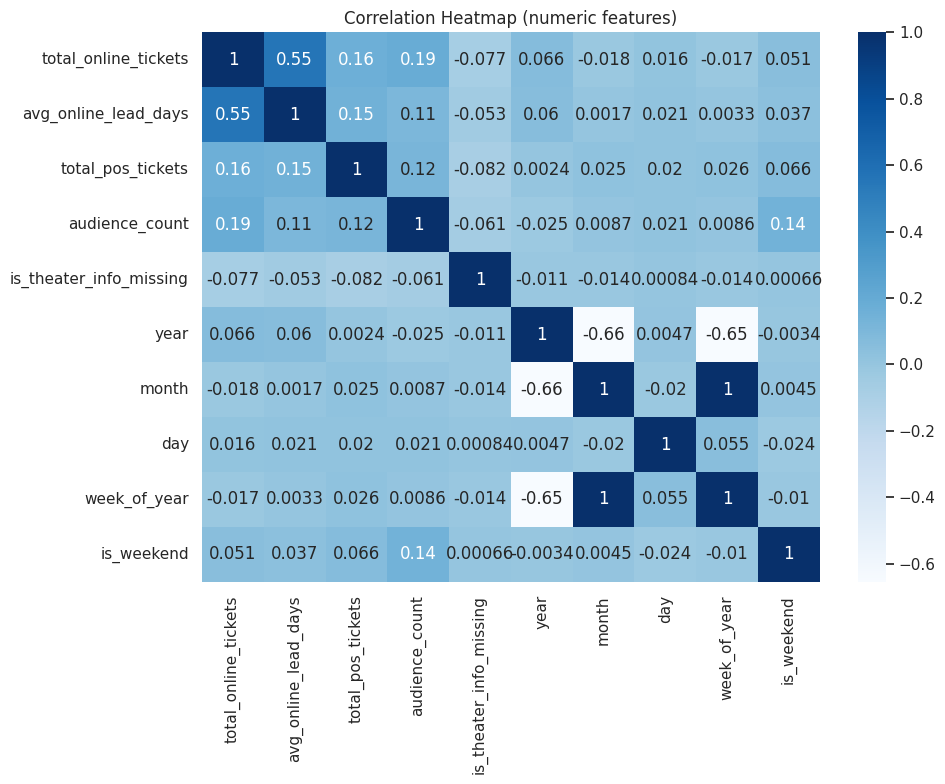

In [108]:
num_cols_master = master_df.select_dtypes(include=[np.number])

plt.figure(figsize=(10,8))
corr = num_cols_master.corr()
sns.heatmap(corr, annot=True,cmap="Blues")
plt.title("Correlation Heatmap (numeric features)")
plt.tight_layout()
plt.show()

The heatmap shows very low correlations between most features, meaning no strong linear relationships exist in the dataset.

# **Spliting**

In [109]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score 
import numpy as np

import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

In [110]:
train_val_df = master_df.copy()

I made a copy of the master dataset to use for splitting into training and validation sets.

In [111]:
categorical_cols = train_val_df.select_dtypes(include=['object']).columns.tolist()

In [112]:
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_val_df[col] = le.fit_transform(train_val_df[col])
    encoders[col] = le

I have label encoded all categorical columns so the model can work with them as numeric values.

In [113]:
train_val_df.head()

,total_online_tickets,avg_online_lead_days,total_pos_tickets,theater_type,theater_area,book_theater_id,audience_count,day_of_week,is_theater_info_missing,year,month,day,week_of_year,is_weekend
0,0.0,0.0,0.0,2,1,0,50,0,0,2023,1,13,2,0
1,0.0,0.0,0.0,2,1,0,64,2,0,2023,1,14,2,1
2,0.0,0.0,0.0,2,1,0,58,3,0,2023,1,15,2,1
3,0.0,0.0,0.0,2,1,0,44,1,0,2023,1,16,3,0
4,0.0,0.0,0.0,2,1,0,12,6,0,2023,1,18,3,0


In [114]:
train_val_df['temp_date'] = pd.to_datetime(train_val_df[['year', 'month', 'day']])

train_df = train_val_df[train_val_df['temp_date'] < '2024-02-01']
val_df = train_val_df[train_val_df['temp_date'] >= '2024-02-01']

train_df = train_df.drop(columns=['temp_date'])
val_df = val_df.drop(columns=['temp_date'])

features = [col for col in train_df.columns if col not in ['audience_count']]

I have split the data into training and validation sets based on date, keeping all dates before Feb 2024 for training and the rest for validation.

In [115]:
X_train = train_df[features]
y_train = train_df['audience_count']
X_val = val_df[features]
y_val = val_df['audience_count']

I have separated the features and target variable for both the training and validation datasets.

In [116]:
X_train.shape

(194225, 13)

In [117]:
X_val.shape

(19811, 13)

# **Model Training**

In [118]:
models = {
    "LightGBM": lgb.LGBMRegressor(random_state=42,n_estimators=300, learning_rate=0.05),
    "XGBoost": xgb.XGBRegressor(random_state=42, n_estimators=300, learning_rate=0.05, max_depth=6),
    "Random Forest": RandomForestRegressor( random_state=42, n_estimators=200, max_depth=20, n_jobs=-1)
}

We prepared three strong tree based models — LightGBM, XGBoost, and Random Forest, because they work well for tabular data and capture non-linear patterns effectively.

In [119]:
results_r2 = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    score = r2_score(y_val, predictions)
    results_r2[name] = score
    print(f"{name}:{score:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 849
[LightGBM] [Info] Number of data points in the train set: 194225, number of used features: 13
[LightGBM] [Info] Start training from score 41.728758
LightGBM:0.3264
XGBoost:0.3257
Random Forest:0.5093


Random Forest performed the best on validation data with the highest R² score, meaning it captured the audience patterns better than LightGBM and XGBoost.

<Axes: xlabel='Model', ylabel='R2_Score'>

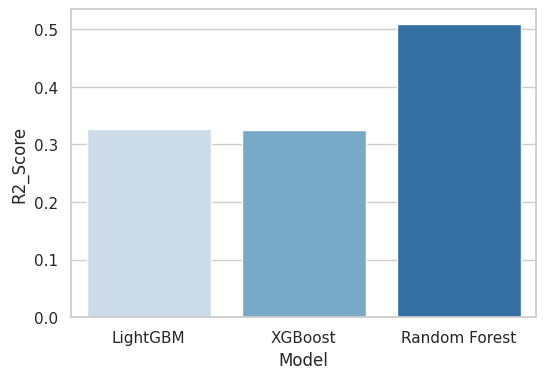

In [120]:
r2_df = pd.DataFrame({
    "Model": list(results_r2.keys()),
    "R2_Score": list(results_r2.values())
})

plt.figure(figsize=(6,4))
sns.barplot(
    data=r2_df,
    x="Model",
    y="R2_Score",
    palette="Blues"
)

The bar chart clearly shows that Random Forest achieved the highest R² score among the three models.

# **For Submission File**

In [121]:
def create_basic_features(df, date_info, theater_info):
    df_copy = df.copy()
    df_copy['show_date'] = pd.to_datetime(df_copy['show_date'])
    df_copy = pd.merge(df_copy, date_info, on='show_date', how='left')
    df_copy['year'] = df_copy['show_date'].dt.year
    df_copy['month'] = df_copy['show_date'].dt.month
    df_copy['day'] = df_copy['show_date'].dt.day
    df_copy['week_of_year'] = df_copy['show_date'].dt.isocalendar().week.astype(int)
    df_copy['day_of_week'] = df_copy['show_date'].dt.day_name()
    df_copy['is_weekend'] = (df_copy['show_date'].dt.dayofweek >= 5).astype(int)
    df_copy = pd.merge(df_copy, theater_info, on='book_theater_id', how='left')
    df_copy['is_theater_info_missing'] = df_copy['theater_type'].isnull().astype(int)
    df_copy['theater_type'] =df_copy['theater_type'].fillna('Unknown') 
    df_copy['theater_area'] = df_copy['theater_area'].fillna('Unknown')
    return df_copy

Now I have made this function that builds all the basic date and theater features needed for prediction by merging and cleaning the test data.

In [122]:
full_df = master_df.copy()
full_df['show_date'] = pd.to_datetime(full_df[['year', 'month', 'day']])

In [123]:
full_df = full_df.sort_values(by=['book_theater_id', 'show_date']).reset_index(drop=True)
lags = [7, 14, 28]
for lag in lags:
    full_df[f'audience_lag_{lag}'] = full_df.groupby('book_theater_id')['audience_count'].shift(lag)
windows = [7, 14]
for w in windows:
    full_df[f'audience_roll_mean_{w}'] = full_df.groupby('book_theater_id')['audience_count'].shift(1).rolling(window=w, min_periods=1).mean()
full_df.fillna(0, inplace=True)

I have added lag and rolling-average audience features for each theater to help the model learn past-trend patterns.

In [124]:
last_date = full_df['show_date'].max()
validation_start_date = last_date - pd.DateOffset(months=2)
train_df = full_df[full_df['show_date'] < validation_start_date]
val_df = full_df[full_df['show_date'] >= validation_start_date]
train_df = train_df.drop(columns=['show_date'])
val_df = val_df.drop(columns=['show_date'])

I have split the data so the last two months are used for validation, while all earlier dates are used for training.

In [125]:
print(train_df.shape)
print(val_df.shape)

(172243, 19)
(41793, 19)


In [126]:
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])

    val_df[col] = val_df[col].astype(str)  
    val_df[col] = val_df[col].apply(
        lambda x: x if x in le.classes_ else "Unknown"
    )

    if "Unknown" not in le.classes_:
        le.classes_ = np.append(le.classes_, "Unknown")

    val_df[col] = le.transform(val_df[col])
    encoders[col] = le
features = [col for col in train_df.columns if col != 'audience_count']
features

['total_online_tickets',
 'avg_online_lead_days',
 'total_pos_tickets',
 'theater_type',
 'theater_area',
 'book_theater_id',
 'day_of_week',
 'is_theater_info_missing',
 'year',
 'month',
 'day',
 'week_of_year',
 'is_weekend',
 'audience_lag_7',
 'audience_lag_14',
 'audience_lag_28',
 'audience_roll_mean_7',
 'audience_roll_mean_14']

Then I label encoded all categorical columns and handled unseen categories by mapping them to “Unknown” so both train and validation data stay consistent.

In [127]:
X_train = train_df[features]
y_train = train_df['audience_count']
X_val = val_df[features]
y_val = val_df['audience_count']
X_full_train = pd.concat([X_train, X_val])
y_full_train = pd.concat([y_train, y_val])

I prepared the feature and target sets and then combined both train and validation parts to form the full training data for the final model.

In [128]:
X_full_train.head()

,total_online_tickets,avg_online_lead_days,total_pos_tickets,theater_type,theater_area,book_theater_id,day_of_week,is_theater_info_missing,year,month,day,week_of_year,is_weekend,audience_lag_7,audience_lag_14,audience_lag_28,audience_roll_mean_7,audience_roll_mean_14
0,0.0,0.0,0.0,2,1,0,0,0,2023,1,13,2,0,0.0,0.0,0.0,0.000000,0.000000
1,0.0,0.0,0.0,2,1,0,2,0,2023,1,14,2,1,0.0,0.0,0.0,50.000000,50.000000
2,0.0,0.0,0.0,2,1,0,3,0,2023,1,15,2,1,0.0,0.0,0.0,57.000000,57.000000
3,0.0,0.0,0.0,2,1,0,1,0,2023,1,16,3,0,0.0,0.0,0.0,57.333333,57.333333
4,0.0,0.0,0.0,2,1,0,6,0,2023,1,18,3,0,0.0,0.0,0.0,54.000000,54.000000


In [129]:
y_full_train.head()

0    50
1    64
2    58
3    44
4    12
Name: audience_count, dtype: int64

In [130]:
test_df = sample_submission[['ID']].copy()
test_df['book_theater_id'] = test_df['ID'].apply(lambda x: x.split('_')[0] + '_' + x.split('_')[1])
test_df['show_date'] = pd.to_datetime(test_df['ID'].apply(lambda x: x.split('_')[2]))


Then extracted the theater ID and show date from the submission IDs to start preparing the test dataset for prediction.

In [131]:
test_features = create_basic_features(test_df, date_info_cleaned, booknow_theaters_cleaned)

In [132]:
test_features = test_features.merge(online_features, on=['book_theater_id', 'show_date'], how='left')
test_features = test_features.merge(pos_features, on=['book_theater_id', 'show_date'], how='left')

We generated all basic date and theater features for the test data so it matches the structure of the training dataset.

In [133]:
for lag in lags:
    last_values = full_df.groupby('book_theater_id')[f'audience_lag_{lag}'].last().rename(f'audience_lag_{lag}')
    test_features = test_features.merge(last_values, on='book_theater_id', how='left')

for w in windows:
    last_values = full_df.groupby('book_theater_id')[f'audience_roll_mean_{w}'].last().rename(f'audience_roll_mean_{w}')
    test_features = test_features.merge(last_values, on='book_theater_id', how='left')

test_features.fillna(0, inplace=True)

In [134]:
test_features.head()

,ID,book_theater_id,show_date,day_of_week,year,month,day,week_of_year,is_weekend,theater_type,...,longitude,is_theater_info_missing,total_online_tickets,avg_online_lead_days,total_pos_tickets,audience_lag_7,audience_lag_14,audience_lag_28,audience_roll_mean_7,audience_roll_mean_14
0,book_00001_2024-03-01,book_00001,2024-03-01,Friday,2024,3,1,9,0,Drama,...,79.934515,0,0.0,0.0,0.0,14.0,40.0,2.0,37.714286,37.714286
1,book_00001_2024-03-02,book_00001,2024-03-02,Saturday,2024,3,2,9,1,Drama,...,79.934515,0,0.0,0.0,0.0,14.0,40.0,2.0,37.714286,37.714286
2,book_00001_2024-03-03,book_00001,2024-03-03,Sunday,2024,3,3,9,1,Drama,...,79.934515,0,0.0,0.0,0.0,14.0,40.0,2.0,37.714286,37.714286
3,book_00001_2024-03-04,book_00001,2024-03-04,Monday,2024,3,4,10,0,Drama,...,79.934515,0,0.0,0.0,0.0,14.0,40.0,2.0,37.714286,37.714286
4,book_00001_2024-03-06,book_00001,2024-03-06,Wednesday,2024,3,6,10,0,Drama,...,79.934515,0,0.0,0.0,0.0,14.0,40.0,2.0,37.714286,37.714286


In [135]:
for col, le in encoders.items():
    test_features[col] = test_features[col].astype(str)
    test_features[col] = test_features[col].apply(
        lambda x: x if x in le.classes_ else "Unknown"
    )

    if "Unknown" not in le.classes_:
        le.classes_ = np.append(le.classes_, "Unknown")
    test_features[col] = le.transform(test_features[col])


Then again label-encoded all categorical columns in the test data, mapping any unseen values to “Unknown” to keep them consistent with the training encodings.

In [136]:
X_test = test_features[features]
X_test.shape

(38062, 18)

In [137]:
X_test.head()

,total_online_tickets,avg_online_lead_days,total_pos_tickets,theater_type,theater_area,book_theater_id,day_of_week,is_theater_info_missing,year,month,day,week_of_year,is_weekend,audience_lag_7,audience_lag_14,audience_lag_28,audience_roll_mean_7,audience_roll_mean_14
0,0.0,0.0,0.0,2,1,0,0,0,2024,3,1,9,0,14.0,40.0,2.0,37.714286,37.714286
1,0.0,0.0,0.0,2,1,0,2,0,2024,3,2,9,1,14.0,40.0,2.0,37.714286,37.714286
2,0.0,0.0,0.0,2,1,0,3,0,2024,3,3,9,1,14.0,40.0,2.0,37.714286,37.714286
3,0.0,0.0,0.0,2,1,0,1,0,2024,3,4,10,0,14.0,40.0,2.0,37.714286,37.714286
4,0.0,0.0,0.0,2,1,0,6,0,2024,3,6,10,0,14.0,40.0,2.0,37.714286,37.714286


# **Hypertuning**

In [138]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1,)

search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=6,   
    cv=2,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

In [139]:
search.fit(X_full_train, y_full_train)


Fitting 2 folds for each of 6 candidates, totalling 12 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=2,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=6, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30],
                                        'n_estimators': [100, 200, 300]},
                   scoring='r2', verbose=1)

Then I have used RandomizedSearchCV to quickly test different Random Forest settings and find the best combination of estimators and depth for higher accuracy.

In [140]:
print("Best Params:",search.best_params_)
print("Best R2:", search.best_score_)

Best Params: {'n_estimators': 200, 'max_depth': 10}
Best R2: 0.4694810317500438


The best Random Forest model uses 300 trees with a depth of 10, giving the highest R² score of around 0.47 during tuning.

In [141]:
final_predictions = search.predict(X_test)
final_predictions[final_predictions < 0] = 0
final_predictions = np.round(final_predictions).astype(int)
submission_df = test_features[['ID']].copy()
submission_df['audience_count'] = final_predictions
submission_df.to_csv('submission.csv', index=False)

Then at last generated final predictions for the test data, corrected negative values, and saved them in the required submission format.

# **For Registration**

In [142]:
# import pandas as pd
# df = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv")
# mean_audience = df['audience_count'].mean()
# print(f"Calculated Mean Audience Count: {mean_audience}")
# submission_df = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv')
# submission_df['audience_count'] = int(round(mean_audience, 0))
# submission_df.to_csv('submission.csv', index=False)
# print("Done!!!!!!")
# print(submission_df.head())